In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Lets start by importing the data into training and testing 

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
# Get the shape of the training and testing set
print('Training data shape', df_train.shape)
print('Testing data shape', df_test.shape)

Training data shape (7613, 5)
Testing data shape (3263, 4)


Now lets get some basic information about the data by viewing the head

In [4]:
# Lets look at the head of the testing and training data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


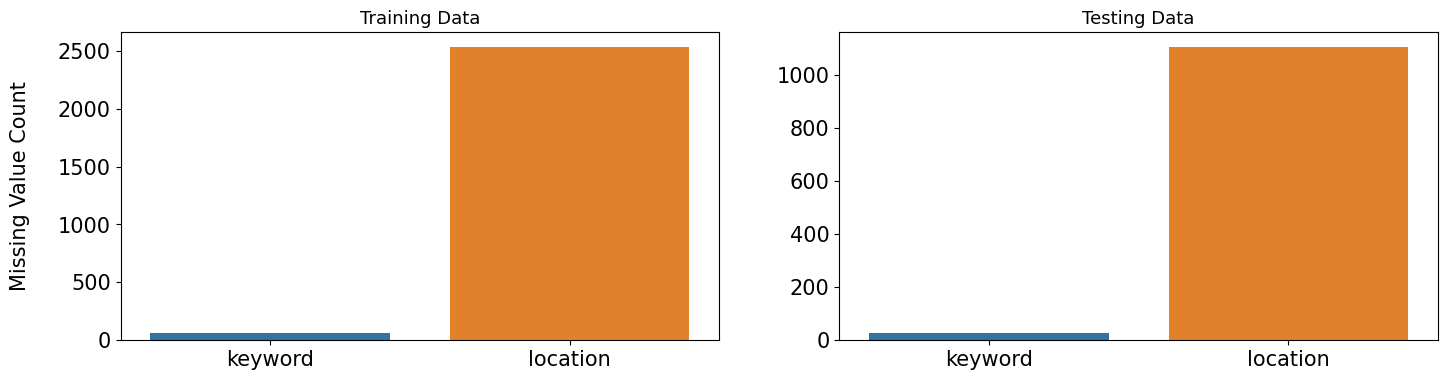

In [6]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols = 2, figsize = (17,4), dpi = 100)

sns.barplot(x = df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])

sns.barplot(x = df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis = 'x', labelsize=15)
axes[0].tick_params(axis = 'y', labelsize=15)
axes[1].tick_params(axis = 'x', labelsize=15)
axes[1].tick_params(axis = 'y', labelsize=15)

axes[0].set_title('Training Data', fontsize=13)
axes[1].set_title('Testing Data', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

As we can see here, both the training data and testing data has a lot of missing values for location parameter.

Now lets divide the data into training and validation sets

In [7]:
batch_size = 32
num_training_samples = df_train.shape[0]

train_split = 0.8
val_split = 0.2
steps_per_epoch = int(num_training_samples) * train_split // batch_size

epoch = 2
auto = tf.data.experimental.AUTOTUNE

In [8]:
X = df_train['text']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_split, random_state = 42)

X_test = df_test['text']

We're going to use the distilBERT model since it is significantly faster than BERT

In [9]:
# Load the BERT model preset
preset = "distil_bert_base_en_uncased"

# Preprocessor: Use a shorter sequence
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length = 160,
    name = "preprocessor_4_tweets"
)

# Pretrained BERT classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor = preprocessor,
    num_classes = 2
)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile the BERT Model
classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = ['accuracy']
)

In [11]:
history = classifier.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epoch,
    validation_data = (X_val, y_val)
)

Epoch 1/2


I0000 00:00:1728595597.501051     118 service.cc:145] XLA service 0x7ea670003f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728595597.501114     118 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728595597.501120     118 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728595621.191985     150 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14690', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1728595628.620750     148 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1728595650.663293     118 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 64 bytes spill stores, 64 bytes spill loads
ptxas 

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7025 - loss: 0.5679

I0000 00:00:1728595746.391873     180 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728595749.439398     183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_247', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728595753.286606     181 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 1256 bytes spill stores, 1212 bytes spill loads

I0000 00:00:1728595774.097803     118 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_27', 64 bytes spill stores, 64 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 205s 707ms/step - accuracy: 0.7033 - loss: 0.5671 - val_accuracy: 0.8418 - val_loss: 0.3898
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 440ms/step - accuracy: 0.8412 - loss: 0.3754 - val_accuracy: 0.8516 - val_loss: 0.3824


Here the model performed decently well, with an accuracy of 0.84 on training and 0.85 on validation

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step


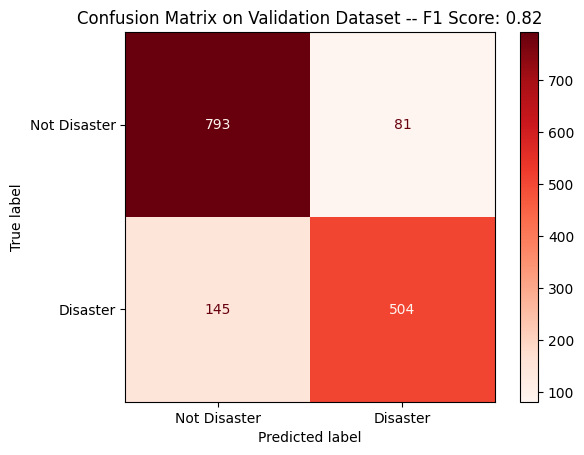

In [12]:
# Generate predictions on the val set
y_pred = classifier.predict(X_val)

def confMatrix(y_true, y_pred, dataset):
    display = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels = ['Not Disaster', 'Disaster'],
        cmap = plt.cm.Reds
    )
    
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))
    display.ax_.set_title(f"Confusion Matrix on {dataset} Dataset -- F1 Score: {f1_score:.2f}")
    plt.show()
    
confMatrix(y_val, y_pred, "Validation")

The confusion matrix shows that the model performs well overall, with a strong ability to correctly classify non-disaster tweets (793 true negatives) and a decent performance for disaster tweets (504 true positives), achieving an F1 score of 0.82. However, there are 145 false negatives, indicating the model could improve in detecting disasters, which may require further tuning or adjusting thresholds.

In [ ]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission.head()

In [ ]:
submission["target"] = np.argmax(classifier.predict(X_test), axis = 1)

In [ ]:
submission.describe()

In [ ]:
submission.to_csv("submission.csv", index=False)